In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG19  
import PIL
import PIL.Image


In [5]:
# Configure GPU settings
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)



In [6]:
# Load all the images
train_dir = r"C:\Users\MMANTC-STL-08\Desktop\IND_Currency_Dataset"
test_dir = r"C:\Users\MMANTC-STL-08\Desktop\test" # New test directory
TARGET_SIZE = 224
BATCH_SIZE = 64



In [7]:
# Data augmentation and loading
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    shuffle=True,
    target_size=(TARGET_SIZE, TARGET_SIZE)
)

print(train_generator.class_indices)


Found 1931 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [8]:
# Using VGG19 model for training (instead of VGG16)
base_model = VGG19(weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE, 3), include_top=False)  # Changed to VGG19
base_model.trainable = False

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    shuffle=False,
    target_size=(TARGET_SIZE, TARGET_SIZE)
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 147s 2us/step
Found 482 images belonging to 2 classes.


In [9]:
# Adding a model on top
inputs = tf.keras.Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

vgg = tf.keras.Model(inputs=inputs, outputs=output)
vgg.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,032,626 (76.42 MB)

 Trainable params: 8,242 (32.20 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
# Compile the model
opt = tf.keras.optimizers.Adam()
cce = tf.keras.losses.CategoricalCrossentropy()
vgg.compile(optimizer=opt, loss=cce, metrics=['accuracy'])



In [11]:
# Define callbacks
checkpoint_filepath = 'model.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)



In [12]:
# Create a new test generator BEFORE the training loop
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False  # We don't shuffle the test data for evaluation
)


Found 177 images belonging to 2 classes.


In [13]:
# Lists to store training/validation/test accuracy and loss after each epoch
train_acc_per_epoch = []
val_acc_per_epoch = []
train_loss_per_epoch = []
val_loss_per_epoch = []
test_acc_per_epoch = []
test_loss_per_epoch = []

EPOCHS = 30
NUM_STEPS = train_generator.samples // BATCH_SIZE
VAL_NUM_STEPS = validation_generator.samples // BATCH_SIZE


In [14]:
# Train the model
for epoch in range(EPOCHS):
    # Train the model for one epoch
    history = vgg.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=NUM_STEPS,
        validation_data=validation_generator,
        validation_steps=VAL_NUM_STEPS,
        callbacks=[reduce_lr, model_checkpoint_callback]
    )
    
    # Store training and validation metrics
    train_acc_per_epoch.append(history.history['accuracy'][0])  # Training accuracy for this epoch
    val_acc_per_epoch.append(history.history['val_accuracy'][0])  # Validation accuracy for this epoch
    train_loss_per_epoch.append(history.history['loss'][0])  # Training loss for this epoch
    val_loss_per_epoch.append(history.history['val_loss'][0])  # Validation loss for this epoch
    
    # Evaluate on the test set at the end of each epoch
    test_loss, test_accuracy = vgg.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
    
    # Store test metrics
    test_acc_per_epoch.append(test_accuracy)
    test_loss_per_epoch.append(test_loss)
    
    # Print progress for the current epoch
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


C:\Users\MMANTC-STL-08\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.6534 - loss: 0.5836 - val_accuracy: 0.8705 - val_loss: 0.3783 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4375 - loss: 1.3250
Epoch 1/30
Test Loss: 1.0170, Test Accuracy: 0.5781
30/30 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.8955 - loss: 0.3159 - val_accuracy: 0.8705 - val_loss: 0.3501 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 1.0743
Epoch 2/30
Test Loss: 0.8394, Test Accuracy: 0.5781
30/30 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.8703 - loss: 0.3493 - val_accuracy: 0.8705 - val_loss: 0.3293 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4375 - loss: 1.0608
Epoch 3/30
Test Loss: 0.8226, Test Accuracy: 0.5781
30/30 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.8882 - loss: 0.2938 - val_accuracy: 0.8728 - val_loss: 0.2927 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4479 - loss: 0.8013
Ep

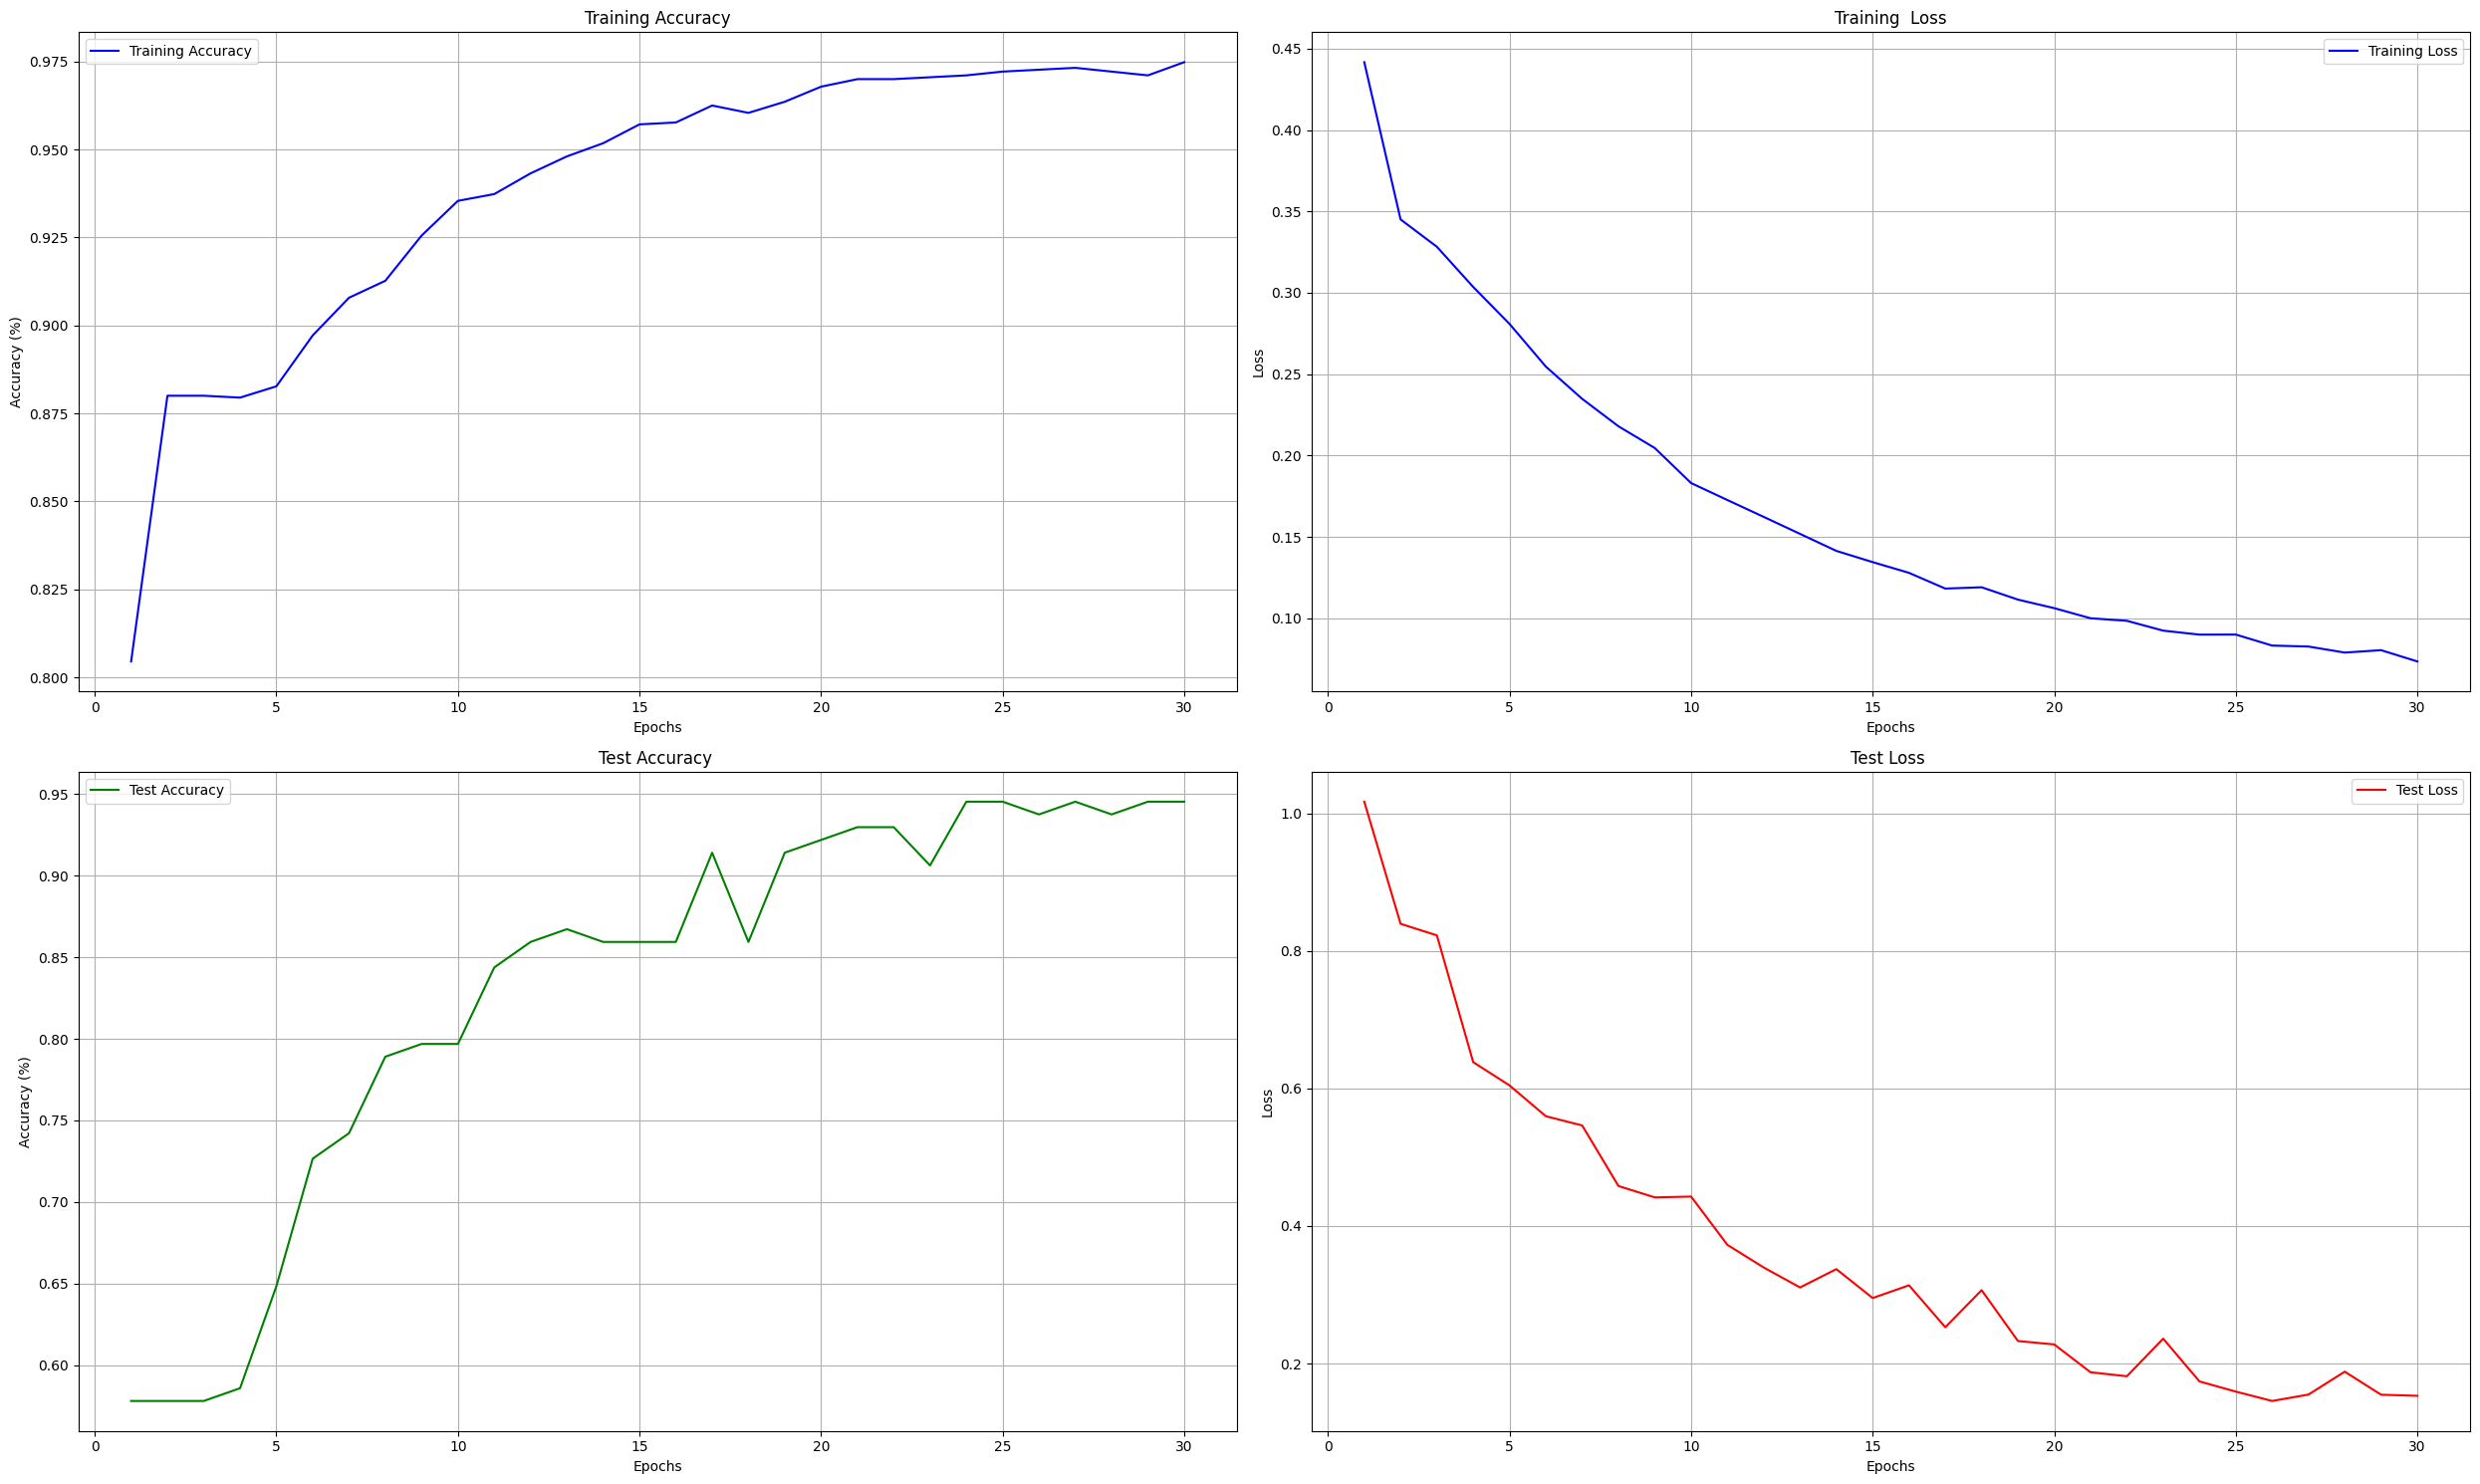

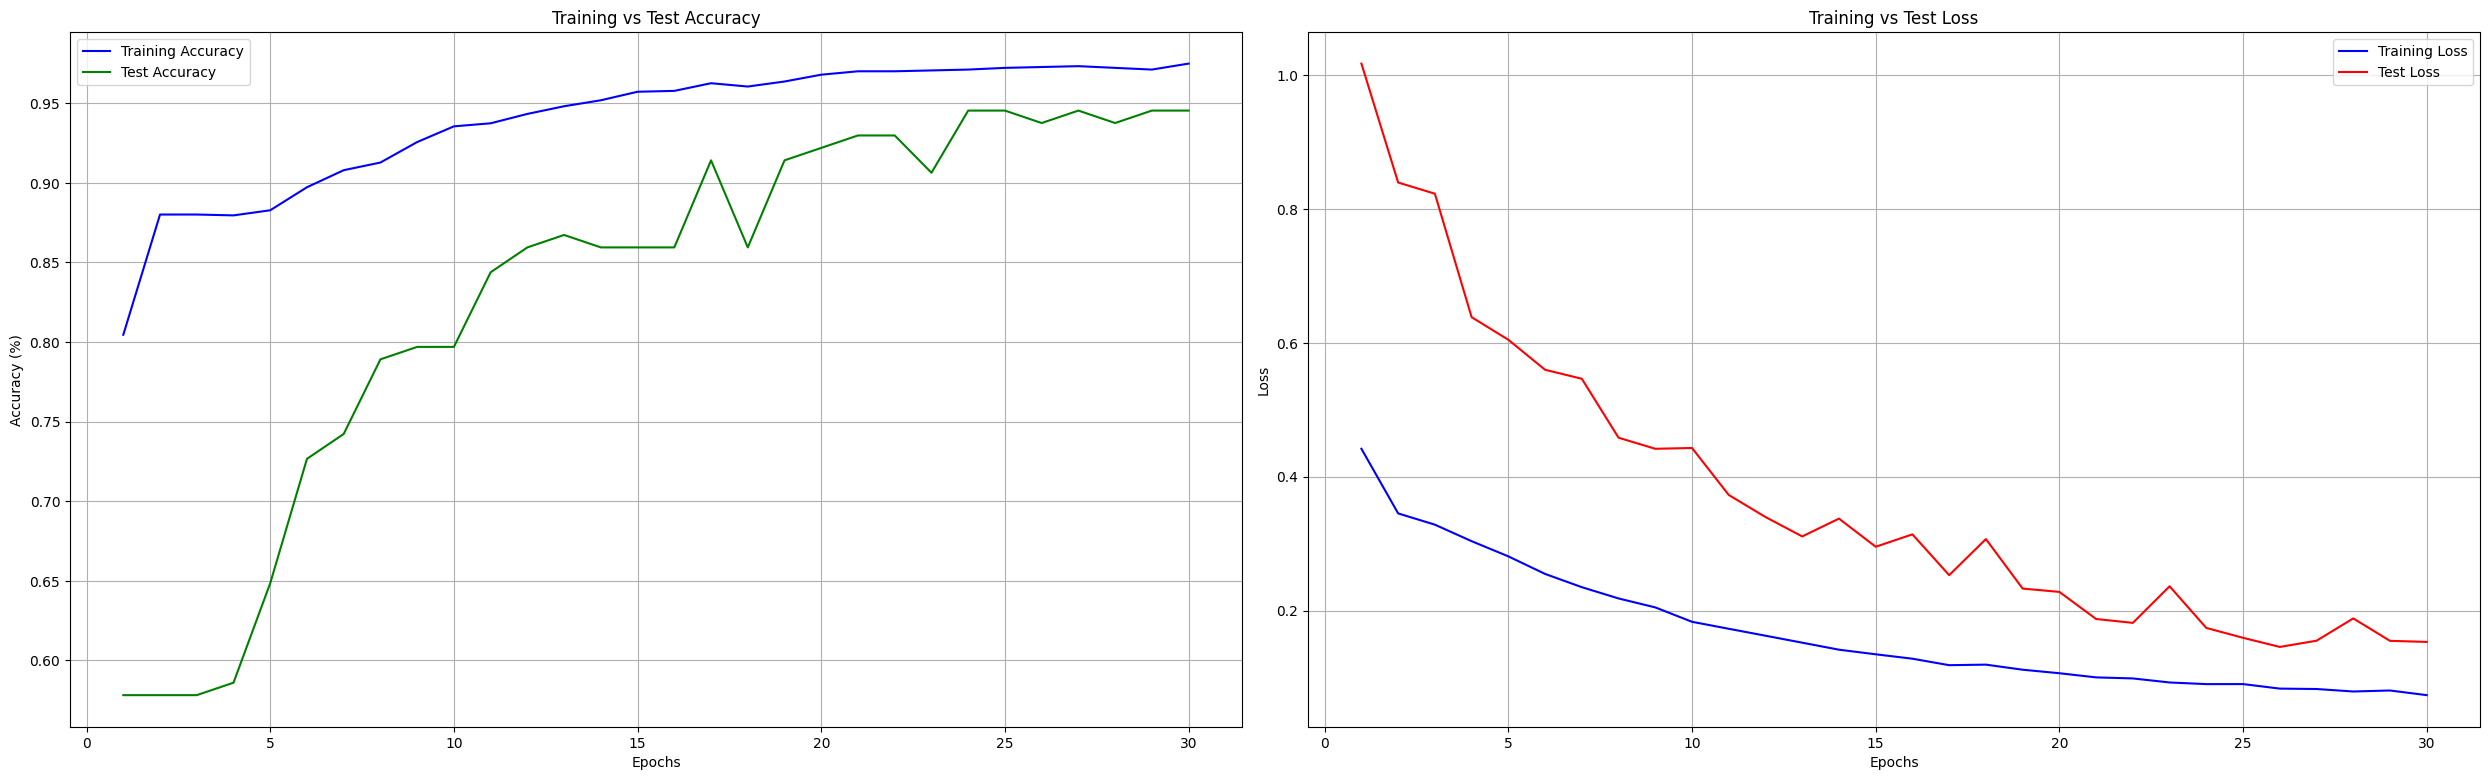

Final Model Loss: 0.0736
Final Model Accuracy: 0.9748
Final Model Loss: 0.0736
Final Model Accuracy: 0.9748


In [15]:
# Plot the training vs. validation accuracy and loss
plt.figure(figsize=(25, 15))

# Plot 1: Training vs Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(1, EPOCHS+1), train_acc_per_epoch, label='Training Accuracy', color='blue')
#plt.plot(range(1, EPOCHS+1), val_acc_per_epoch, label='Validation Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 2: Training vs Validation Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, EPOCHS+1), train_loss_per_epoch, label='Training Loss', color='blue')
#plt.plot(range(1, EPOCHS+1), val_loss_per_epoch, label='Validation Loss', color='orange')
plt.title('Training  Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot 3: Test Accuracy per Epoch
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, label='Test Accuracy', color='green')
plt.title('Test Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 4: Test Loss per Epoch
plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS+1), test_loss_per_epoch, label='Test Loss', color='red')
plt.title('Test Loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
plt.figure(figsize=(25, 15)) 

# Plot 5: Training vs Test Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), train_acc_per_epoch, label='Training Accuracy', color='blue')
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, label='Test Accuracy', color='green')
plt.title('Training vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 6: Training vs Test Loss
plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS+1), train_loss_per_epoch, label='Training Loss', color='blue')
plt.plot(range(1, EPOCHS+1), test_loss_per_epoch, label='Test Loss', color='red')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Adjust layout to ensure all plots fit nicely
plt.tight_layout()

# Show the plots
plt.show()

# Print final model loss and accuracy
final_loss = history.history['loss'][-1]  # Final training loss (from the last epoch)
final_accuracy = history.history['accuracy'][-1]  # Final training accuracy (from the last epoch)

print(f'Final Model Loss: {final_loss:.4f}')
print(f'Final Model Accuracy: {final_accuracy:.4f}')

# Print final model loss and accuracy
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f'Final Model Loss: {final_loss:.4f}')
print(f'Final Model Accuracy: {final_accuracy:.4f}')
